<center>
<h1>Energy Model Building Flow - Example 2</h1>
<h2>for platforms supporting system-level energy meters</h2>
</center>

This notebook shows how to build an energy model of a HiKey960 platform running an Android Linux kernel.

It can be used as a reference implementation of an energy model building flow for platforms<br>
where it's possible to measure the energy consumption at system level, that is either at battery<br>
level or as close as possible to the clusters.

In this case, it is not enough to isolate the CPUs of the target cluster, but we also have to make<br>
sure that all tasks (except the essential ones) are **frozen** to avoid affecting battery power<br>
measurements. This will be achieved by exploiting the cgroup `freezer` controller.

# Configuration

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-11-21 14:47:46,938 INFO    : root         : Using LISA logging configuration:
2017-11-21 14:47:46,940 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

In [3]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'hikey960',
    
    "device"      : "HEATERPRO",

    "results_dir" : "EnergyModel_SystemEnergy",

    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "acme",
        "conf" : {
            'ip_address' : '192.168.0.1'
        },
        "channel_map" : {
            "Shunt" : "1"
        }
    },

    # Tools required by the experiments
    "tools"   : ['trace-cmd', 'sysbench'],
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 200 * 1024,
    },
}

In [4]:
!adb root

adbd is already running as root


In [5]:
# Initialize a test environment using:
# the provided target configuration (my_conf)
te = TestEnv(target_conf=my_conf, force_new=True)
target = te.target

2017-11-21 14:47:47,839 INFO    : TestEnv      : Using base path: /data/work/lisa
2017-11-21 14:47:47,841 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-11-21 14:47:47,842 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-11-21 14:47:47,843 WARNING : TestEnv      :    /data/work/lisa/results/EnergyModel_SystemEnergy
2017-11-21 14:47:47,845 INFO    : TestEnv      : External tools using:
2017-11-21 14:47:47,846 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/
2017-11-21 14:47:47,847 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools//platform-tools/systrace/catapult
2017-11-21 14:47:47,848 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2017-11-21 14:47:47,850 INFO    : TestEnv      : Connecting Android target [HEATERPRO]
2017-11-21 14:47:47,851 INFO    : TestEnv      : Connection settings:
2017-11-21 14:47:47,853 INFO    : TestEnv      

## Critical tasks declaration
Energy measured of a cluster at system-level is affected by noise due the other clusters running in the system. To limit effect of this noise we exploit the `freezer cpuset` controller to freeze the tasks already running in the system. However, we need to be careful not to freeze those tasks that allow us to communicate with the target.

Hence, we define here-below a list of tasks called *CRITICAL* that must not be frozen.

In [6]:
# Lists of critical tasks for each platform
CRITICAL_TASKS = {
    'linux': ["init", "sh"],
    'android': ["/system/bin/sh", "adbd", "/init"]
    }

## Energy Model Parameters (CPUs, OPPs and Idle States)
Cluster data will be extracted automatically from the target device.

### Platform cluster layout discovery

In [7]:
clusters = {}

for cpu, cluster in enumerate(target.core_clusters):
    if cluster not in clusters:
        clusters[cluster] = {}
        clusters[cluster]["cpus"] = []
        
    clusters[cluster]["cpus"].append(cpu)
    
for cluster in clusters.itervalues():
    first_cpu = cluster["cpus"][0]
    
    cluster["freqs"] = target.cpufreq.list_frequencies(first_cpu)
    cluster["idles"] = range(len(target.cpuidle.get_states(first_cpu)))

In [8]:
for cluster, values in clusters.iteritems():
    print "===== cluster {} =====".format(cluster)
    print "CPUs {}".format(values["cpus"])
    print "freqs {}".format(values["freqs"])
    print "idle states {}".format(values["idles"])

===== cluster 0 =====
CPUs [0, 1, 2, 3]
freqs [533000, 999000, 1402000, 1709000, 1844000]
idle states [0, 1, 2]
===== cluster 1 =====
CPUs [4, 5, 6, 7]
freqs [903000, 1421000, 1805000, 2112000, 2362000]
idle states [0, 1, 2, 3]


### Energy meter configuration
The Notebook will try to guess the energy meter channel to use. If it can't, you'll have to specify it manually.

In [9]:
if len(my_conf["emeter"]["channel_map"]) == 1:
    em_channel = my_conf["emeter"]["channel_map"].keys()[0]
    logging.info("Will use channel '{}' for energy measurements".format(em_channel))
else:
    logging.info("More than one emeter channel, please specify which one to use")

2017-11-21 14:47:53,742 INFO    : root         : Will use channel 'Shunt' for energy measurements


## Device setup

### Thermal management
Thermal management will be disabled (at least the software part, there quite likely is some sort of in-hardware/firmware protection) to not impact the energy readings. If your device overheats easily, you could try using a fan to cool it.

In [10]:
target.thermal.disable_all_zones()

### Temperature sensor
A temperature sensor is needed to ensure each test iteration is run in roughly the same conditions (i.e. the same temperature). In this example we'll use the sensor used by a thermal zone, but any other method could be used as long as a **get_temperature()** method can be called.

In [11]:
temperature_sensor = target.thermal.zones[0]

### Custom settings
If your device requires any more setting up, such as writing to sysfs files, do it here.

## Benchmark example
In this section, we setup classes that will give us an API to trigger and then analyse any benchmarking application

In [12]:
class EM_workload(object):
    """
    Energy Model workload class
    
    :param target: Devlib target to run the workload on
    :type target: devlib.target
    
    :param binary: Path to the workload binary on the target
    :type binary: str
    
    :param duration: Execution duration of the workload
    :type duration: int
    
    :param args: Additional arguments to be given to the binary call
    :type args: str or list(str)
    """
    
    def __init__(self, target, binary, duration, args=None):
        self.target = target
        self.binary = binary
        self.duration = duration
        self.args = args
        
    def run(self, cpus):
        """
        Launch len('cpus') executions of 'binary', one per cpu
        
        :param cpus: CPU list of CPUs that will run this workload
        :type cpus: list(int)
        
        :returns: The cumulative score of each workload as a dict(cpu : score)
        """
        self.procs = {}
        for cpu in cpus:
            self.procs[cpu] = self.target.background_invoke(binary=self.binary, args=self.args, on_cpus=[cpu])
            
        stderr = {}
        stdout = {}
        for cpu in cpus:
            stderr[cpu], stdout[cpu] = self.procs[cpu].communicate()
            
        score = {}
        for cpu in cpus:
            score[cpu] = self._parse_score(stderr[cpu], stdout[cpu])
        
        return score
    
    def _parse_score(self, stderr, stdout):
        raise NotImplemented("_parse_score must be implemented")

In [13]:
class EM_dhrystone(EM_workload):
    
    def __init__(self, target, binary, duration, args=None):
        EM_workload.__init__(self, target, binary, duration)
        self.args = duration

    def _parse_score(self, stderr, stdout):
        match = re.search('(?P<score>[0-9]+) loops', stdout)
        return float(match.group('score'))

In [14]:
class EM_sysbench(EM_workload):
    
    def __init__(self, target, binary, duration, args=None):
        EM_workload.__init__(self, target, binary, duration)
        self.args = '--test=cpu --max-time={} run'.format(duration)

    def _parse_score(self, stderr, stdout):
        match = re.search('total number of events:\s*(?P<events>[0-9]+)', stderr)
        return float(match.group('events'))

# Energy Model Building

## Power performance analysis
In this section, we will look at the power/performance characteristics of the platform. We will also collected data for the C-states modelling.

In [15]:
class power_perf_recorder(object):
    """
    Data collector for C-states analysis
    
    :param clusters: Dictionnary describing the clusters to analyze
        Format: {
            cluster_name : {
                "cpus"  : [0, 1],
                "freqs" : [100, 200]
            }
        }
    :type clusters: dict
    
    :param benchmark: instance of an EM_workload subclass
    :type benchmark: EM_workload
    
    :param channel: Name of the energy meter channel to use for energy collection
    :type channel: str
    """
    
    def __init__(self, clusters, benchmark, channel):
        self.clusters = clusters
        self.benchmark = benchmark
        self.channel = channel
        
    @property
    def online_cpus(self):
        return target.list_online_cpus()
        
    def _read_energy(self):
        energy = 0.0
        perf = { cpu : 0.0 for cpu in self.online_cpus }

        for i in xrange(self.loop_cnt):
            te.emeter.reset()

            for cpu, value in self.benchmark.run(self.online_cpus).iteritems():
                perf[cpu] += value

            nrg = te.emeter.report(te.res_dir).channels
            energy += float(nrg[self.channel])
            
            # Wait for temperature to drop down under a given threshold
            while temperature_sensor.get_temperature() > self.test_temperature:
                sleep(1)
                
        for cpu in perf.iterkeys():
            perf[cpu] = perf[cpu] / self.loop_cnt
            
        energy = energy / self.loop_cnt

        return (perf, energy)
    
    def _set_and_check_freq(self, cpu, freq):
        target.cpufreq.set_frequency(cpu, freq)
        rfreq = target.cpufreq.get_frequency(cpu)

        if rfreq != freq:
            raise RuntimeError("Requested freq {}, got {}".format(freq, rfreq))
    
    def _analysis_setup(self):
        # Make sure all CPUs are online
        target.hotplug.online_all()
        # Set cpufreq governor to userpace to allow manual frequency scaling
        target.cpufreq.set_all_governors('userspace')
        # Freeze all userspace tasks
        target.cgroups.freeze(exclude=CRITICAL_TASKS['android'])
        
        self.data = []
        
        # Prepare backup file writer
        self._fh = open(self.bkp_file, 'w')
        self._writer = DictWriter(
            self._fh,
            fieldnames=['cluster', 'cpus', 'freq', 'perf', 'energy', 'power']
        )
        
        # Read current temperature
        self.test_temperature = 0
        for i in range(10):
            self.test_temperature += temperature_sensor.get_temperature()
        self.test_temperature /= 10
        
        logging.info("Test ambient temperature determined as: {}".format(self.test_temperature))
            
        
    def _analysis_teardown(self):
        # Restore device status
        target.cgroups.freeze(thaw=True)
        target.hotplug.online_all()
        
        # Cleanup backup fh
        self._fh.close()
        
    def _measure_noise(self):
        if self.noise_cpu < 0:
            self.noise_nrg = 0
            return
        
        onlines = self.online_cpus
        
         # Offline all cpus but noise cpu
        target.hotplug.online(self.noise_cpu)
        for cpu in onlines:
            if cpu != self.noise_cpu:
                target.hotplug.offline(cpu)
        
        # Measure energy with noise cpu        
        self._set_and_check_freq(self.noise_cpu, clusters[self.noise_cluster]["freqs"][0])
        _, self.noise_nrg = self._read_energy()
        
        # Restore previously online cpus
        for cpu in onlines:
            target.hotplug.online(cpu)
        
    def _setup_analysis_cluster(self, cluster_idx):

        self.cur_cluster = cluster_idx
        online_cluster = self.clusters[cluster_idx]
        online_cpu = online_cluster["cpus"][0]
        
        # Make sure one core of the cluster is online
        target.hotplug.online(online_cpu)
        
        # Offline all other cores
        for cluster in self.clusters.itervalues():
            for cpu in cluster["cpus"]:
                if cpu != online_cpu:
                    target.hotplug.offline(cpu)
                    
        # See if we can use another cluster for energy comparison
        if len(self.clusters) < 2:
            self.noise_cluster = -1
            self.noise_cpu = -1
        else:
            self.noise_cluster = (cluster_idx + 1) % len(self.clusters)
            self.noise_cpu = self.clusters[self.noise_cluster]["cpus"][0]
            
        self._measure_noise()
        
    def _setup_analysis_cpu(self, cpu):
        target.hotplug.online(cpu)
        
    def _analyse(self, freq):
        self._set_and_check_freq(self.clusters[self.cur_cluster]["cpus"][0], freq)
        
        # Subtract noise energy
        perf, energy = self._read_energy()
        energy -= self.noise_nrg
        
        # Remove performance result from noise-measurement CPU
        perf.pop(self.noise_cpu, None)

        res = {
            'cluster': self.cur_cluster,
            'cpus': len(perf),
            'freq': freq,
            'perf': sum(perf.values()),
            'energy' : energy,
            'power': energy / self.benchmark.duration
        }
        
        # Save data to backup file
        self._writer.writerow(res)
        
        # Save data locally
        self.data.append(res)
    
    def run_analysis(self, loop_cnt, bkp_file='pstates.csv'):
        """
        This will record energy values for the P-states of the target.
        Energy will be recorded with an increasing amount of active CPUs (from 1 to all of the cluster's CPUs),
        for all available frequencies. This will be done on each cluster.
        
        :param loop_cnt: Number of iterations for each benchmark execution
        :type loop_cnt: int
        
        :param bkp_file: File in which the recorded data will be appended
            Useful to resume the analysis after closing the Notebook
        :type bkp_file: str
        """
        self.loop_cnt = loop_cnt
        self.bkp_file = bkp_file
        
        try:
            self._analysis_setup()
            # A) For each cluster
            for cluster_idx in self.clusters.iterkeys():
                logging.info("Cluster={}".format(cluster_idx))
                self._setup_analysis_cluster(cluster_idx)
                # B) For each core of that cluster
                for cpu in clusters[cluster_idx]["cpus"]:
                    self._setup_analysis_cpu(cpu)
                    logging.info("Online cpus={}".format(self.online_cpus))
                    
                    # C) For each supported OPP
                    for freq in clusters[cluster_idx]["freqs"]:
                        logging.info("Freq={}".format(freq))
                        self._analyse(freq)
        finally:
            self._analysis_teardown()
        
        df = pd.DataFrame(self.data)

        return df.set_index(['cluster', 'freq', 'cpus']).sort_index(level='cluster')

In [16]:
sysbench = EM_sysbench(target, target.which("sysbench"), 5)
pp_recorder = power_perf_recorder(clusters, sysbench, em_channel)

In [17]:
#dhry = EM_dhrystone(target, target.which("dhry2"), 2)
#pp_recorder = power_perf_recorder(clusters, dhry, em_channel)

In [18]:
power_perf = pp_recorder.run_analysis(loop_cnt=25)

2017-11-21 14:47:56,018 INFO    : root         : Test ambient temperature determined as: 36501
2017-11-21 14:47:56,020 INFO    : root         : Cluster=0
2017-11-21 14:49:55,704 INFO    : root         : Online cpus=[0, 4]
2017-11-21 14:49:55,706 INFO    : root         : Freq=533000
2017-11-21 14:51:53,147 INFO    : root         : Freq=999000
2017-11-21 14:53:50,357 INFO    : root         : Freq=1402000
2017-11-21 14:55:47,570 INFO    : root         : Freq=1709000
2017-11-21 14:57:44,723 INFO    : root         : Freq=1844000
2017-11-21 14:59:41,205 INFO    : root         : Online cpus=[0, 1, 4]
2017-11-21 14:59:41,208 INFO    : root         : Freq=533000
2017-11-21 15:01:38,669 INFO    : root         : Freq=999000
2017-11-21 15:03:36,158 INFO    : root         : Freq=1402000
2017-11-21 15:05:33,582 INFO    : root         : Freq=1709000
2017-11-21 15:07:31,062 INFO    : root         : Freq=1844000
2017-11-21 15:09:28,877 INFO    : root         : Online cpus=[0, 1, 2, 4]
2017-11-21 15:09:

In [19]:
power_perf

energy          perf       power
cluster freq    cpus                                      
0       533000  1       185.7544  3.741691e+06     92.8772
                2       297.3336  7.483614e+06    148.6668
                3       414.1312  1.122325e+07    207.0656
                4       521.7540  1.496672e+07    260.8770
        999000  1       389.8252  7.026158e+06    194.9126
                2       645.0084  1.404970e+07    322.5042
                3       941.7292  2.107734e+07    470.8646
                4      1202.7452  2.810125e+07    601.3726
        1402000 1       641.1576  9.871226e+06    320.5788
                2      1139.6848  1.974726e+07    569.8424
                3      1653.2540  2.961850e+07    826.6270
                4      2159.0964  3.949212e+07   1079.5482
        1709000 1       967.6488  1.204300e+07    483.8244
                2      1743.6320  2.408205e+07    871.8160
                3      2530.4560  3.612809e+07   1265.2280
                4      3286.6396  4.817117e+07   1643.3198
        1844000 1      1277.0624  1.298938e+07    638.5312
                2      2325.0792  2.597955e+07   1162.5396
                3      3366.4112  3.897229e+07   1683.2056
                4      4387.4384  5.196575e+07   2193.7192
1       903000  1       981.4388  1.096745e+07    490.7194
                2      1789.1856  2.194019e+07    894.5928
                3      2611.0788  3.290758e+07   1305.5394
                4      3429.9568  4.387886e+07   1714.9784
        1421000 1      1951.1760  1.728119e+07    975.5880
                2      3637.5972  3.455896e+07   1818.7986
                3      5425.6496  5.183162e+07   2712.8248
                4      7082.9212  6.911899e+07   3541.4606
        1805000 1      3205.2896  2.195790e+07   1602.6448
                2      6117.8424  4.390955e+07   3058.9212
                3      8896.5616  6.586245e+07   4448.2808
                4     11784.1324  8.783000e+07   5892.0662
        2112000 1      4616.3780  2.570022e+07   2308.1890
                2      9040.8248  5.140012e+07   4520.4124
                3     13292.6224  7.707552e+07   6646.3112
                4     18071.3240  1.025695e+08   9035.6620
        2362000 1      6700.6228  2.873374e+07   3350.3114
                2     12660.3860  5.747494e+07   6330.1930
                3     19046.9916  8.587342e+07   9523.4958
                4     25444.2284  1.091829e+08  12722.1142

### Power / Thermal capping filtering
Due to power capping (e.g. PMU limitations) and/or thermal capping (e.g. in-firmware protection or even different performance results at different temperatures), the energy readings can be "corrupted" at higher OPPs.

In this first part, the energy evolution will be plotted. If at some point an energy curve's gradient is smaller than at a previous point, it means the readings have been impacted.

In [20]:
def plot_bench_nrg(power_perf_df, cluster):

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    for cpus, df in power_perf_df.loc[cluster].groupby(level='cpus'):
        freqs = df.index.get_level_values("freq").tolist()
        energy = df["energy"].tolist()

        p = ax.plot(freqs, energy)
        ax.scatter(freqs, energy, label="{} active cpus".format(cpus), color=p[-1].get_color())
        plt.xticks(freqs)

    ax.set_title("Cluster {} energy consumption evolution".format(cluster), fontsize=15)
    ax.set_ylabel("Energy reading (bogo-joule)", fontsize=15)
    ax.set_xlabel("Frequency (Hz)", fontsize=15)
    ax.legend(loc="upper left")
    ax.grid(True)

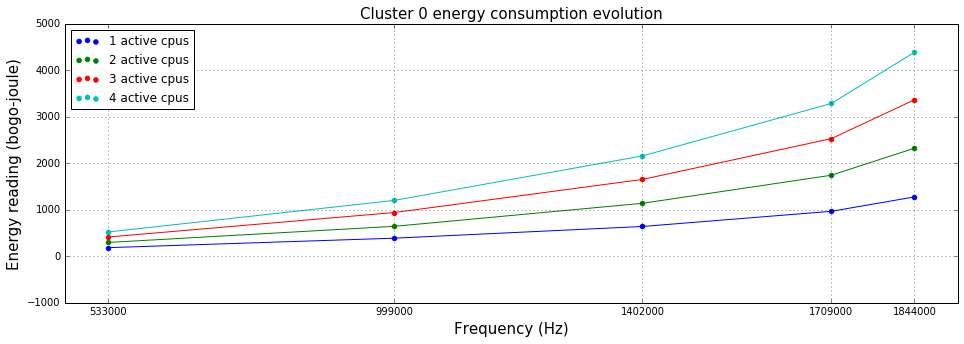

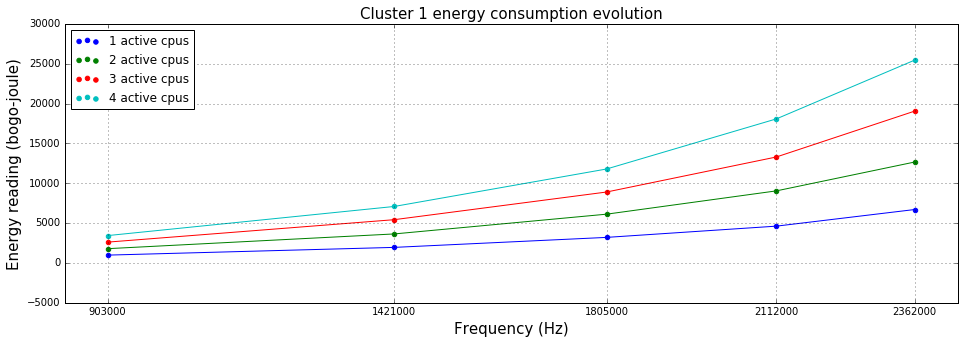

In [21]:
for cluster in clusters:
    plot_bench_nrg(power_perf, cluster)

In this second part, we'll remove the lines that have this gradient anomaly.

In [22]:
def filter_bench_nrg(power_perf_df):
    
    def comp_delta(a, b):
        return (b[1] - a[1]) / (b[0] - a[0])

    expunge = []
    for cluster in power_perf_df.index.levels[0].tolist():
        cl_power_df = power_perf_df.loc[cluster].reset_index()       
        for cpu, df in cl_power_df.groupby('cpus'):

            first_point = [df.iloc[0]["freq"], df.iloc[0]["energy"]]
            prev_point = [df.iloc[1]["freq"], df.iloc[1]["energy"]]
            
            delta_prev = comp_delta(first_point, prev_point)

            for idx in range(len(df))[2:]:
                cur_point = [df.iloc[idx]["freq"], df.iloc[idx]["energy"]]

                delta = comp_delta(prev_point, cur_point)

                if delta_prev > delta * 1.05:
                    if (cluster, cpu) not in expunge:
                        expunge.append((cluster, cpu))

                delta_prev = delta
                prev_point = cur_point

    tmp = power_perf_df.reset_index()
    for couple in expunge:
        # Remove entire lines where at least one anomaly was found
        tmp = tmp[~((tmp["cpus"] == couple[1]) & (tmp["cluster"] == couple[0]))]
    tmp = tmp.set_index(['cluster', 'freq', 'cpus']).sort_index(level='cluster')
    return tmp

In [23]:
power_perf_new = filter_bench_nrg(power_perf)

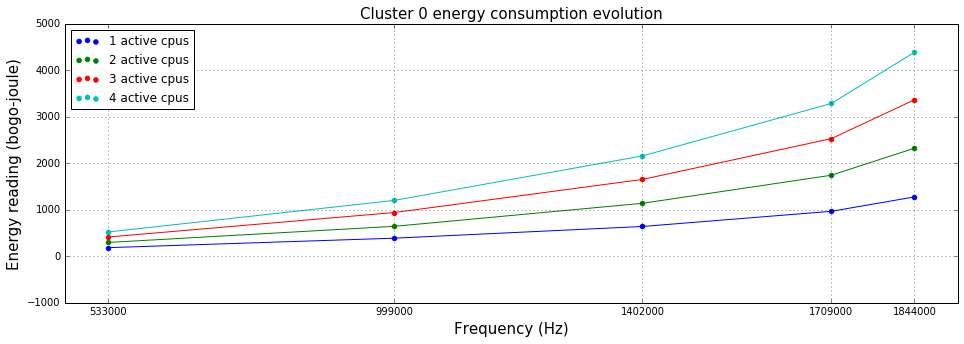

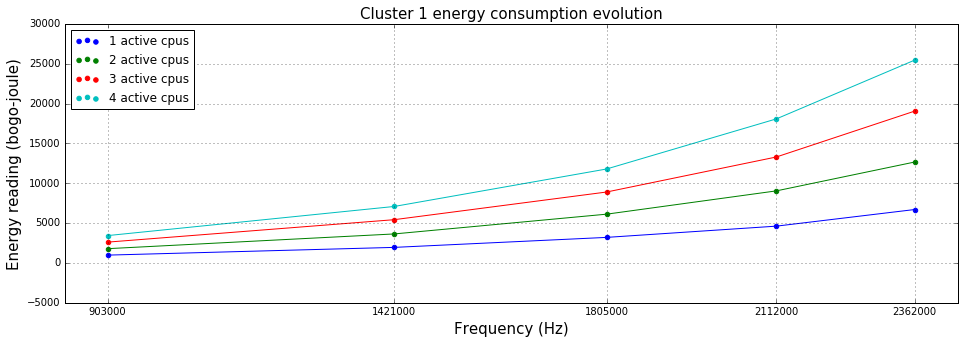

In [24]:
for cluster in clusters:
    plot_bench_nrg(power_perf_new, cluster)

### Statistical analysis
Now that the data has been sanitized, we can build statistics out of it.

In [25]:
def power_perf_stats(power_perf_df):
    """
    For each cluster compute per-OPP power and performance statistics.
    
    :param power_perf_df: dataframe containing power and performance numbers
    :type power_perf_df: :mod:`pandas.DataFrame`
    """
    clusters = power_perf_df.index.get_level_values('cluster')\
                                  .unique().tolist()
        
    stats = {
        "avg": {
            "func": "mean",
            "args": [],
        },
        "std": {
            "func": "std",
            "args": [],
        },
        "min": {
            "func": "min",
            "args": [],
        },
        "max": {
            "func": "max",
            "args": [],
        },
        "c99": {
            "func": "quantile",
            "args": [0.99],
        },
    }

    data = []   
    for cl in clusters:
        cl_power_df = power_perf_df.loc[cl].reset_index()

        
        for freq, df in cl_power_df.groupby('freq'):
            perf = df['perf'] / df['cpus']
            power = df['power'] / df['cpus']
            energy = df['energy'] / df['cpus']
            
            for name, info in stats.iteritems():
                data.append({
                    'cluster': cl,
                    'freq': freq,
                    'stats': name,
                    'perf': getattr(perf, info["func"])(*info["args"]),
                    'power': getattr(power, info["func"])(*info["args"]),
                    'energy': getattr(energy, info["func"])(*info["args"])
                })
    
    stats_df = pd.DataFrame(data).set_index(['cluster', 'freq', 'stats'])\
                                  .sort_index(level='cluster')
    return stats_df.unstack()

In [26]:
pp_stats = power_perf_stats(power_perf_new)

In [27]:
def plot_power_perf(pp_stats, clusters):
    cmap = ColorMap(len(clusters) + 1)
    color_map = map(cmap.cmap, range(len(clusters) + 1))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    max_perf = pp_stats.perf['avg'].max()
    max_power = pp_stats.power['avg'].max()

    for i, cl in enumerate(clusters):
        cl_df = pp_stats.loc[i]
        norm_perf_df = cl_df.perf['avg'] * 100.0 / max_perf
        norm_power_df = cl_df.power['avg'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, color=color_map[i], marker='o', label=i)

        # Plot upper bounds
        norm_perf_df = cl_df.perf['max'] * 100.0 / max_perf
        norm_power_df = cl_df.power['max'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, '--', color=color_map[-1])

        # Plot lower bounds
        norm_perf_df = cl_df.perf['min'] * 100.0 / max_perf
        norm_power_df = cl_df.power['min'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, '--', color=color_map[-1])

    ax.set_title('Power VS Performance curves', fontsize=16)
    ax.legend()
    ax.set_xlabel('Performance [%]')
    ax.set_ylabel('Power [%]')
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True)

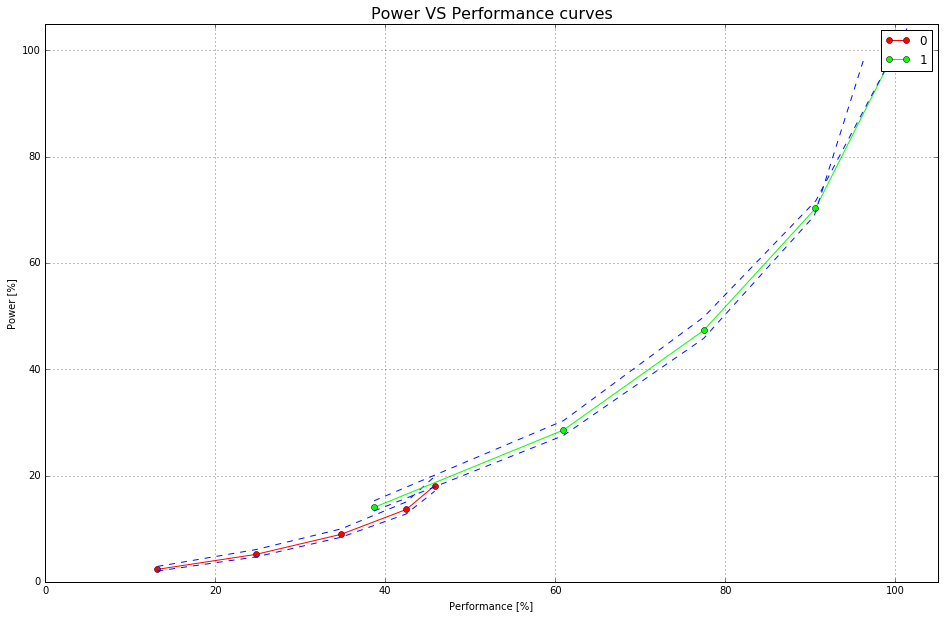

In [28]:
plot_power_perf(pp_stats, clusters)

In [29]:
def linfit(x, y):
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept

In [30]:
def pstates_model_df(clusters, pp_stats, power_perf_df, metric='avg'):
    """
    Build two data frames containing data to create the energy model for each
    cluster given as input.
    
    :param clusters: list of clusters to profile
    :type clusters: list(namedtuple(ClusterDescription))
    
    :param pp_stats: power and performance statistics
    :type pp_stats: :mod:`pandas.DataFrame`
    
    :param power_perf_df: power and performance data
    :type power_perf_df: :mod:`pandas.DataFrame`
    
    :param metric: Statistical metric to apply on measured energy
    :type metric: str
    """
    max_score = pp_stats.perf[metric].max()

    core_cap_energy = []
    cluster_cap_energy = []
    for cl in clusters:
        # ACTIVE Energy
        grouped = power_perf_df.loc[cl].groupby(level='freq')
        for freq, df in grouped:
            # Get <metric> energy at OPP freq for 1 CPU
            energy_freq_1 = pp_stats.loc[cl].loc[freq]['energy'][metric]
            # Get cluster energy at OPP freq
            x = df.index.get_level_values('cpus').tolist()
            y = df.energy.tolist()
            
            slope, intercept = linfit(x, y)
            # Energy can't be negative but the regression line may intercept the
            # y-axis at a negative value. In this case cluster energy can be
            # assumed to be 0.
            cluster_energy = intercept if intercept >= 0.0 else 0.0
            core_energy = energy_freq_1 - cluster_energy

            # Get score at OPP freq
            score_freq = pp_stats.loc[cl].loc[freq]['perf'][metric]
            capacity = int(score_freq * 1024 / max_score)

            core_cap_energy.append({'cluster' : cl,
                                    'freq': freq,
                                    'cap': capacity,
                                    'energy': core_energy})
            cluster_cap_energy.append({'cluster': cl,
                                       'freq': freq,
                                       'cap': capacity,
                                       'energy': cluster_energy})

    core_cap_nrg_df = pd.DataFrame(core_cap_energy)
    cluster_cap_nrg_df = pd.DataFrame(cluster_cap_energy)
    return core_cap_nrg_df, cluster_cap_nrg_df

The energy measured while running with $n$ CPUs **is not** $n \times Energy\_of\_one\_CPU$.
For this reason, we will use a different metric, like for instance the 99th percentile.

In [31]:
core_cap_nrg_df, cluster_cap_nrg_df = pstates_model_df(clusters,
                                                       pp_stats,
                                                       power_perf_new,
                                                       metric='c99'
                                                      )

In [32]:
core_cap_nrg_df

,cap,cluster,energy,freq
0,133,0,111.097572,533000
1,250,0,276.848770,999000
2,351,0,507.566344,1402000
3,429,0,768.628816,1709000
4,462,0,1027.743916,1844000
5,390,1,817.780220,903000
6,615,1,1718.690678,1421000
7,782,1,2828.753948,1805000
8,915,1,4512.370632,2112000
9,1024,1,6381.734229,2362000


In [33]:
cluster_cap_nrg_df

,cap,cluster,energy,freq
0,133,0,73.5442,533000
1,250,0,110.9568,999000
2,351,0,131.4518,1402000
3,429,0,196.1450,1709000
4,462,0,245.8828,1844000
5,390,1,161.0532,903000
6,615,1,228.5140,1421000
7,782,1,372.1446,1805000
8,915,1,101.1284,2112000
9,1024,1,308.7016,2362000


There can still be issues in the modelling, and sometimes energy model values are non-monotonic. For this reason, the energy costs will be post-processed and monotinized if needed.

In [34]:
def monotonize_costs(nrg_costs_df):
    res = nrg_costs_df.copy()
    
    for cluster in nrg_costs_df["cluster"].unique():
        costs = res[res.cluster == cluster]
        erroneous = []
        
        prev = 0
        for row in costs.iterrows():
            idx = row[0]
            cap = row[1]["cap"]
            energy = row[1]["energy"]
            freq = row[1]["freq"]
            
            if energy < prev:
                erroneous.append((idx, cap))
                logging.info("cluster={} capacity={} has non-monotonic energy value, adjusting...".format(cluster, cap))
            else:
                prev = energy
        
        # All values were monotic, move to next cluster
        if not erroneous:
            continue
            
        valid = costs[~costs.cap.isin([grp[1] for grp in erroneous])]

        for idx, cap in erroneous:
            x = valid["cap"].tolist()
            y = valid["energy"].tolist()

            # Create a polynomial plot with values that are known to be valid
            # TODO: polynomial fit may not be monotonic in some weird corner cases, need to improve this
            p = polyfit(x, y, 2)
            # Fit "invalid" data onto this curve
            fix = sum(p * [cap * cap, cap, 1])
            
            res.set_value(idx, 'energy', fix)
        
    return res

In [35]:
core_cap_nrg_df = monotonize_costs(core_cap_nrg_df)

In [36]:
cluster_cap_nrg_df = monotonize_costs(cluster_cap_nrg_df)

2017-11-21 16:14:05,703 INFO    : root         : cluster=1 capacity=915.0 has non-monotonic energy value, adjusting...
2017-11-21 16:14:05,704 INFO    : root         : cluster=1 capacity=1024.0 has non-monotonic energy value, adjusting...


In [37]:
core_cap_nrg_df

,cap,cluster,energy,freq
0,133,0,111.097572,533000
1,250,0,276.848770,999000
2,351,0,507.566344,1402000
3,429,0,768.628816,1709000
4,462,0,1027.743916,1844000
5,390,1,817.780220,903000
6,615,1,1718.690678,1421000
7,782,1,2828.753948,1805000
8,915,1,4512.370632,2112000
9,1024,1,6381.734229,2362000


In [38]:
cluster_cap_nrg_df

,cap,cluster,energy,freq
0,133,0,73.544200,533000
1,250,0,110.956800,999000
2,351,0,131.451800,1402000
3,429,0,196.145000,1709000
4,462,0,245.882800,1844000
5,390,1,161.053200,903000
6,615,1,228.514000,1421000
7,782,1,372.144600,1805000
8,915,1,543.557236,2112000
9,1024,1,721.737120,2362000


## Idle States Profiling

In [39]:
def compute_idle_power(clusters, loop_cnt, sleep_duration, bkp_file='cstates.csv'):
    """
    Perform C-States profiling on each input cluster.
    
    Data will be saved into a CSV file at each iteration such that if something
    goes wrong the user can restart the experiment considering only idle_states
    that had not been processed.
    
    :param clusters: list of clusters to profile
    :type clusters: list(namedtuple(ClusterDescription))
    
    :param loop_cnt: number of loops for each experiment
    :type loop_cnt: int
    
    :param sleep_duration: sleep time in seconds
    :type sleep_duration: int
    
    :param bkp_file: CSV file name
    :type bkp_file: str
    """

    # Make sure all CPUs are online
    target.hotplug.online_all()

    with open(bkp_file, 'w') as csvfile:
        writer = DictWriter(csvfile, fieldnames=['cluster', 'cpus', 'idle_state',
                                                 'energy', 'power'])

        # Disable frequency scaling by setting cpufreq governor to userspace
        target.cpufreq.set_all_governors('userspace')

        # Freeze all tasks but the ones to communicate with the target
        target.cgroups.freeze(exclude=CRITICAL_TASKS['android'])

        all_cpus = set(range(target.number_of_cpus))
        idle_power = []
        for cl_idx, cl in clusters.iteritems():

            # In current cluster, hotplug OFF all CPUs but the first one
            # At least one CPU must be online
            target.hotplug.online(cl["cpus"][0])
            for cpu in cl["cpus"][1:]:
                target.hotplug.offline(cpu)

            other_cpus = list(all_cpus - set(cl["cpus"]))
            # CPUs in the other clusters will be kept hotplugged OFF
            # to not affect measurements on the current cluster
            for cpu in other_cpus:
                target.hotplug.offline(cpu)

            # B) For each additional cluster's plugged in CPU...
            for cnt, cpu in enumerate(cl["cpus"]):
                
                # Hotplug ON one more CPU
                target.hotplug.online(cpu)
                
                cl_cpus = set(target.list_online_cpus()).intersection(set(cl["cpus"]))
                logging.info('Cluster {:8} (Online CPUs : {})'\
                              .format(cl_idx, list(cl_cpus)))
                
                for idle in cl["idles"]:

                    # Disable all idle states but the current one
                    logging.info("Disabling all idle states other than state {}".format(idle))
                    for c in cl["cpus"]:
                        target.cpuidle.disable_all(cpu=c)
                        target.cpuidle.enable(idle, cpu=c)

                    sleep(3)
                    # Sleep for the specified duration each time collecting a sample
                    # of energy consumption and reported performance
                    energy = 0.0
                    for i in xrange(loop_cnt):
                        te.emeter.reset()
                        sleep(sleep_duration)
                        nrg = te.emeter.report(te.res_dir).channels
                        energy += float(nrg[em_channel])

                    # Compute average energy and performance for the current number of
                    # active CPUs all idle at the current OPP
                    energy = energy / loop_cnt
                    power = energy / SLEEP_DURATION

                    # Keep track of this new C-State profiling point
                    new_row = {'cluster': cl_idx,
                               'cpus': cnt + 1,
                               'idle_state': idle,
                               'energy': energy,
                               'power': power}
                    idle_power.append(new_row)

                    # Save data in a CSV file
                    writer.writerow(new_row)
                    
                # C) profile next C-State

            # B) add one more CPU (for the current frequency domain)

        # A) profile next cluster (i.e. frequency domain)

        # Thaw all tasks in the freezer cgroup
        target.cgroups.freeze(thaw=True)
        target.hotplug.online_all()

        idle_df = pd.DataFrame(idle_power)
    return idle_df.set_index(['cluster', 'idle_state', 'cpus']).sort_index(level='cluster')

In [40]:
SLEEP_DURATION = 10
loop_cnt = 10

idle_df = compute_idle_power(clusters, loop_cnt, SLEEP_DURATION)

2017-11-21 16:14:09,379 INFO    : root         : Cluster        0 (Online CPUs : [0])
2017-11-21 16:14:09,381 INFO    : root         : Disabling all idle states other than state 0
2017-11-21 16:16:22,204 INFO    : root         : Disabling all idle states other than state 1
2017-11-21 16:18:35,035 INFO    : root         : Disabling all idle states other than state 2
2017-11-21 16:20:48,413 INFO    : root         : Cluster        0 (Online CPUs : [0, 1])
2017-11-21 16:20:48,415 INFO    : root         : Disabling all idle states other than state 0
2017-11-21 16:23:00,962 INFO    : root         : Disabling all idle states other than state 1
2017-11-21 16:25:13,542 INFO    : root         : Disabling all idle states other than state 2
2017-11-21 16:27:26,756 INFO    : root         : Cluster        0 (Online CPUs : [0, 1, 2])
2017-11-21 16:27:26,759 INFO    : root         : Disabling all idle states other than state 0
2017-11-21 16:29:39,306 INFO    : root         : Disabling all idle states 

In [41]:
WFI = 0
CORE_OFF = 1

def idle_power_stats(idle_df):
    """
    For each cluster compute per idle state power statistics.
    
    :param idle_df: dataframe containing power numbers
    :type idle_df: :mod:`pandas.DataFrame`
    """

    stats = []
    for cl in clusters.iterkeys():
        cl_df = idle_df.loc[cl].reset_index()
        # Start from deepest idle state
        cl_df = cl_df.sort_values('idle_state', ascending=False)
        grouped = cl_df.groupby('idle_state', sort=False)
        for state, df in grouped:
            energy = df.energy
            power = df.power
            state_name = "C{}_CLUSTER".format(state)
            if state == CORE_OFF:
                core_off_nrg_avg = energy.mean()
                core_off_pwr_avg = power.mean()
            if state == WFI:
                energy = df.energy.diff()
                energy[0] = df.energy[0] - core_off_nrg_avg
                power = df.power.diff()
                power[0] = df.power[0] - core_off_pwr_avg
                state_name = "C0_CORE"

            avg_row = {'cluster': cl,
                       'idle_state': state_name,
                       'stats': 'avg',
                       'energy': energy.mean(),
                       'power': power.mean()
                      }
            std_row = {'cluster': cl,
                       'idle_state': state_name,
                       'stats': 'std',
                       'energy': energy.std(),
                       'power': power.std()
                      }
            min_row = {'cluster' : cl,
                       'idle_state' : state_name,
                       'stats' : 'min',
                       'energy' : energy.min(),
                       'power' : power.min()
                      }
            max_row = {'cluster' : cl,
                       'idle_state' : state_name,
                       'stats' : 'max',
                       'energy' : energy.max(),
                       'power' : power.max()
                      }
            c99_row = {'cluster' : cl,
                       'idle_state' : state_name,
                       'stats' : 'c99',
                       'energy' : energy.quantile(q=0.99),
                       'power' : power.quantile(q=0.99)
                      }
            stats.append(avg_row)
            stats.append(std_row)
            stats.append(min_row)
            stats.append(max_row)
            stats.append(c99_row)
    
    stats_df = pd.DataFrame(stats).set_index(
        ['cluster', 'idle_state', 'stats']).sort_index(level='cluster')
    return stats_df.unstack()

In [42]:
idle_stats = idle_power_stats(idle_df)

In [43]:
idle_df

energy      power
cluster idle_state cpus                      
0       0          1     29307.150  2930.7150
                   2     29306.161  2930.6161
                   3     29306.842  2930.6842
                   4     29307.282  2930.7282
        1          1     29296.951  2929.6951
                   2     29298.968  2929.8968
                   3     29298.728  2929.8728
                   4     29296.140  2929.6140
        2          1     29085.263  2908.5263
                   2     29086.096  2908.6096
                   3     29089.870  2908.9870
                   4     29092.040  2909.2040
1       0          1     32582.742  3258.2742
                   2     32621.712  3262.1712
                   3     33103.026  3310.3026
                   4     33600.987  3360.0987
        1          1     32339.977  3233.9977
                   2     32376.689  3237.6689
                   3     32593.683  3259.3683
                   4     32596.513  3259.6513
        2          1     32354.978  3235.4978
                   2     32356.995  3235.6995
                   3     32358.662  3235.8662
                   4     32360.175  3236.0175
        3          1     29129.123  2912.9123
                   2     29141.734  2914.1734
                   3     29147.829  2914.7829
                   4     29151.799  2915.1799

In [44]:
def plot_cstates(idle_power_df, clusters):
    """
    Plot C-States profiling for the specified cluster.
    
    :param idle_power_df: dataframe reporting power values in each idle state
    :type idle_power_df: :mod:`pandas.DataFrame`

    :param cluster: cluster description
    :type cluster: namedtuple(ClusterDescription)
    """
    
    for cl_idx, cluster in clusters.iteritems():
        n_cpus = len(cluster["cpus"])
        cmap = ColorMap(len(cluster["idles"]))
        color_map = map(cmap.cmap, cluster["idles"])
        color_map = [c for c in color_map for i in xrange(n_cpus)]

        cl_df = idle_power_df.loc[cl_idx]
        ax = cl_df.power.plot.bar(figsize=(16,8), color=color_map, alpha=0.5,
                                  legend=False, table=True)

        idx = 0
        grouped = cl_df.groupby(level=0)
        for state, df in grouped:
            x = df.index.get_level_values('cpus').tolist()
            y = df.power.tolist()
            print x
            print y
            slope, intercept = linfit(x, y)

            y = [slope * v + intercept for v in x]
            x = range(n_cpus * idx, n_cpus * (idx + 1))
            print x
            print y
            ax.plot(x, y, color=color_map[idx*n_cpus], linewidth=4)
            idx += 1

        ax.grid(True)
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel("Idle Power [$\mu$W]")
        ax.set_title("{} cluster C-states profiling"\
                     .format(cluster), fontsize=16)

In [45]:
def plot_cstates(idle_power_df, clusters):
    """
    Plot C-States profiling for the specified cluster.
    
    :param idle_power_df: dataframe reporting power values in each idle state
    :type idle_power_df: :mod:`pandas.DataFrame`

    :param cluster: cluster description
    :type cluster: namedtuple(ClusterDescription)
    """
    
    n_clusters = len(clusters)
    fig, ax = plt.subplots(nrows = n_clusters, figsize = (16, 8 * n_clusters))
    
    for cl_idx, cluster in clusters.iteritems():
        n_cpus = len(cluster["cpus"])
        cmap = ColorMap(len(cluster["idles"]))
        color_map = map(cmap.cmap, cluster["idles"])
        color_map = [c for c in color_map for i in xrange(n_cpus)]

        _ax = ax[cl_idx] if n_clusters > 1 else ax
        
        cl_df = idle_power_df.loc[cl_idx]
        cl_df.power.plot.bar(figsize=(16, 8 * n_clusters), color=color_map, alpha=0.5,
                                  legend=False, table=True, ax=_ax)

        idx = 0
        grouped = cl_df.groupby(level=0)
        for state, df in grouped:
            x = df.index.get_level_values('cpus').tolist()
            y = df.power.tolist()
            slope, intercept = linfit(x, y)

            y = [slope * v + intercept for v in x]
            x = range(n_cpus * idx, n_cpus * (idx + 1))
            _ax.plot(x, y, color=color_map[idx*n_cpus], linewidth=4)
            idx += 1

        _ax.grid(True)
        _ax.get_xaxis().set_visible(False)
        _ax.set_ylabel("Idle Power [$\mu$W]")
        _ax.set_title("{} cluster C-states profiling"\
                     .format(cluster), fontsize=16)

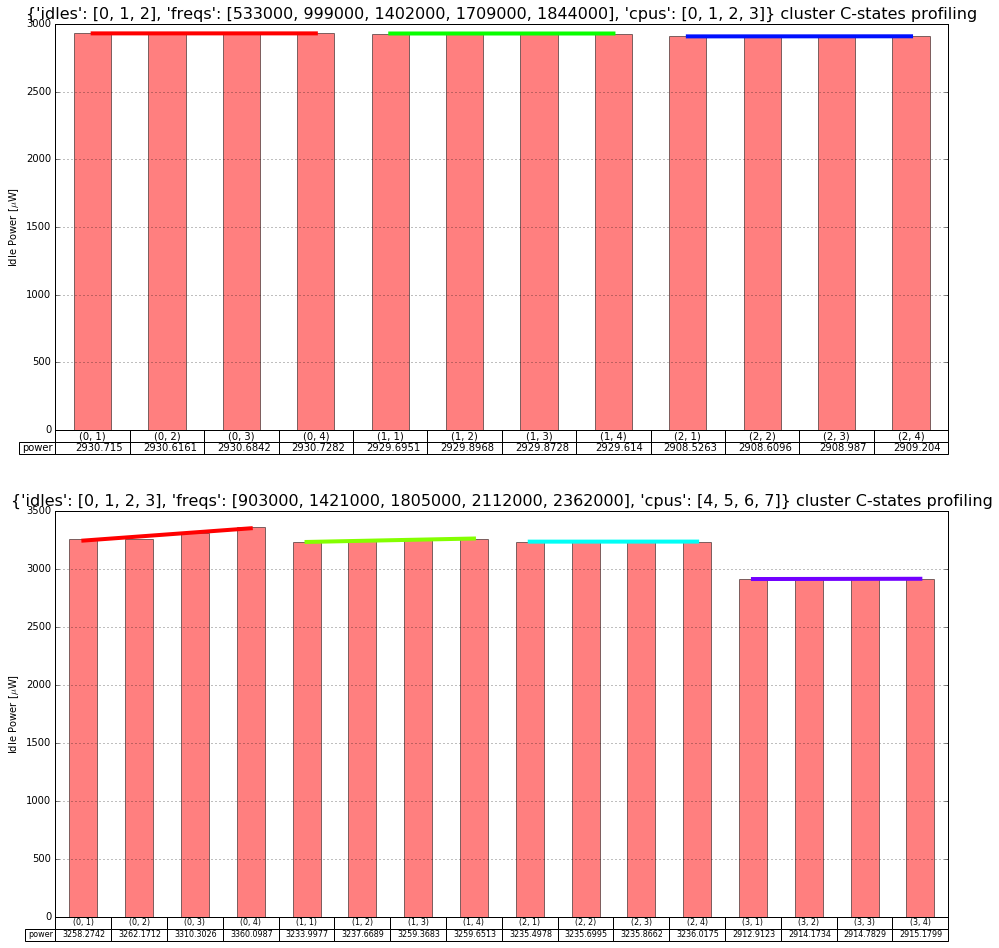

In [46]:
plot_cstates(idle_df, clusters)

# Energy Model Generation
All of the required data has been collected and post-processed, we can now generate an energy model that can be plugged in the platform's devicetree

In [47]:
core_cap_nrg_df["cap"]

0     133
1     250
2     351
3     429
4     462
5     390
6     615
7     782
8     915
9    1024
Name: cap, dtype: int64

In [48]:
grouped = core_cap_nrg_df.groupby('cluster')

In [49]:
for cl, df in grouped:
    for row in df.itertuples():
        print row

Pandas(Index=0, cap=133, cluster=0, energy=111.09757200000044, freq=533000)
Pandas(Index=1, cap=250, cluster=0, energy=276.84876999999892, freq=999000)
Pandas(Index=2, cap=351, cluster=0, energy=507.56634399999962, freq=1402000)
Pandas(Index=3, cap=429, cluster=0, energy=768.62881600000048, freq=1709000)
Pandas(Index=4, cap=462, cluster=0, energy=1027.7439159999985, freq=1844000)
Pandas(Index=5, cap=390, cluster=1, energy=817.78021999999976, freq=903000)
Pandas(Index=6, cap=615, cluster=1, energy=1718.6906779999974, freq=1421000)
Pandas(Index=7, cap=782, cluster=1, energy=2828.7539479999996, freq=1805000)
Pandas(Index=8, cap=915, cluster=1, energy=4512.3706319999983, freq=2112000)
Pandas(Index=9, cap=1024, cluster=1, energy=6381.7342290000015, freq=2362000)


In [50]:
def energy_model_dict(clusters, core_cap_nrg_df, cluster_cap_nrg_df, metric='avg'):
    n_states = len(clusters[0]["idles"])

    nrg_dict = {}

    grouped = core_cap_nrg_df.groupby('cluster')
    for cl, df in grouped:
        nrg_dict[cl] = {
            "opps" : {},
            "core": {
                "busy-cost": OrderedDict(),
                "idle-cost": OrderedDict()
            },
            "cluster": {
                "busy-cost": OrderedDict(),
                "idle-cost": OrderedDict()
            }
        }
        # Core COSTS
        # ACTIVE costs
        for row in df.itertuples():
            nrg_dict[cl]["opps"][row.cap] = row.freq
            nrg_dict[cl]["core"]["busy-cost"][row.cap] = int(row.energy)

        # IDLE costs
        wfi_nrg = idle_stats.loc[cl].energy[metric][0]
        # WFI
        nrg_dict[cl]["core"]["idle-cost"][0] = int(wfi_nrg)
        # All remaining states are zeroes
        for i in xrange(1, n_states):
            nrg_dict[cl]["core"]["idle-cost"][i] = 0

        # Cluster COSTS
        cl_data = cluster_cap_nrg_df[cluster_cap_nrg_df.cluster == cl]
        # ACTIVE costs
        for row in cl_data.itertuples():
            nrg_dict[cl]["cluster"]["busy-cost"][row.cap] = int(row.energy)

        # IDLE costs
        # Core OFF is the first valid idle cost for cluster
        idle_data = idle_stats.loc[cl].energy[metric]
        # WFI (same as Core OFF)
        nrg_dict[cl]["cluster"]["idle-cost"][0] = int(idle_data[1])
        # All other idle states (from CORE OFF down)
        for i in xrange(1, n_states):
            nrg_dict[cl]["cluster"]["idle-cost"][i] = int(idle_data[i])

    return nrg_dict

In [51]:
nrg_dict = energy_model_dict(clusters, core_cap_nrg_df, cluster_cap_nrg_df)

In [52]:
def dump_device_tree(nrg_dict, outfile='sched-energy.dtsi'):
    """
    Generate device tree energy model file.
    
    :param nrg_dict: dictionary describing the energy model
    :type nrg_dict: dict
    
    :param outfile: output file name
    :type outfile: str
    """
    with open(os.path.join(te.res_dir, outfile), 'w') as out:
        out.write("energy-costs {\n")
        idx = 0
        for cl_name in nrg_dict.keys():
            core = nrg_dict[cl_name]["core"]
            # Dump Core costs
            out.write("\tCPU_COST_{}: core_cost{} {}\n"\
                      .format(idx, idx, '{'))
            # ACTIVE costs
            out.write("\t\tbusy-cost-data = <\n")
            for cap, nrg in core["busy-cost"].iteritems():
                out.write("\t\t\t{} {}\n".format(cap, nrg))
            out.write("\t\t>;\n")
            # IDLE costs
            out.write("\t\tidle-cost-data = <\n")
            # arch idle
            out.write("\t\t\t{}\n".format(core["idle-cost"][0]))
            for nrg in core["idle-cost"].values():
                out.write("\t\t\t{}\n".format(nrg)) 
            out.write("\t\t>;\n")
            out.write("\t};\n")

            # Dump Cluster costs
            cl = nrg_dict[cl_name]["cluster"]
            out.write("\tCLUSTER_COST_{}: cluster_cost{} {}\n"\
                      .format(cl_name, idx, '{'))
            # ACTIVE costs
            out.write("\t\tbusy-cost-data = <\n")
            for cap, nrg in cl["busy-cost"].iteritems():
                out.write("\t\t\t{} {}\n".format(cap, nrg))
            out.write("\t\t>;\n")
            # IDLE costs
            out.write("\t\tidle-cost-data = <\n")
            # arch idle
            out.write("\t\t\t{}\n".format(cl["idle-cost"][0]))
            for nrg in cl["idle-cost"].values():
                out.write("\t\t\t{}\n".format(nrg))
            out.write("\t\t>;\n")
            out.write("\t};\n")
            idx += 1
        out.write("};")

In [53]:
dump_device_tree(nrg_dict)

In [54]:
!cat {te.res_dir}/sched-energy.dtsi

energy-costs {
	CPU_COST_0: core_cost0 {
		busy-cost-data = <
			133 111
			250 276
			351 507
			429 768
			462 1027
		>;
		idle-cost-data = <
			2
			2
			0
			0
		>;
	};
	CLUSTER_COST_0: cluster_cost0 {
		busy-cost-data = <
			133 73
			250 110
			351 131
			429 196
			462 245
		>;
		idle-cost-data = <
			29297
			29297
			29297
			29088
		>;
	};
	CPU_COST_1: core_cost1 {
		busy-cost-data = <
			390 817
			615 1718
			782 2828
			915 4512
			1024 6381
		>;
		idle-cost-data = <
			281
			281
			0
			0
		>;
	};
	CLUSTER_COST_1: cluster_cost1 {
		busy-cost-data = <
			390 161
			615 228
			782 372
			915 543
			1024 721
		>;
		idle-cost-data = <
			32476
			32476
			32476
			32357
		>;
	};
};